# Slice Sampling

##### Keywords: data augmentation, slice sampling, MCMC

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
from scipy.stats import norm

import sys
from IPython import display

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


$$
\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\corr}{{\rm corr}}
\newcommand{\xss}{x^{(i+1)}}
\newcommand{\xs}{x^{\star}}
\newcommand{\xt}{x^{(i)}}
\newcommand{\yss}{y^{(i+1)}}
\newcommand{\ys}{y^{\star}}
\newcommand{\yt}{y^{(i)}}
\newcommand{\xa}{x_a}
\newcommand{\xb}{x_b}
$$

## Why?

We've already studied two MCMC variants, Gibbs Sampling and Metropolis-Hastings.  These are the foundational (and in many senses, original) MCMC methods.  Both methods are based on **random walk** Markov Chains.  You may have started to notice, or at least suspect, that there are many situation in which we want greater flexibity in exploring the probability space than waht a random walk Markov Chain provides.  

One of the methods that we'll look at is Slice Sampling.  Slice sampling was invented by Radfor Neal and John Skilling.  It is a very elegant and simple way to solve the problems of MH and Gibbs sampling. As Pavlos would say, its conceptually so easy you would think his (very capable) grandma invented it...

Slice Sampling is geared to approach the following problem with Methropolis-Hastings.  Metropolis Hastings is very sensitive to the width of the proposal step.  You can tune the Metropolis-Hastings algorithm by choosing a proposal in such a way as to determine the width of the proposal distribution for each variable.  Unfortunately satisfying detailed-balance provides a constraint preventing any proposal width scale parameters from being set based on past iterations of the current chain.
 

### Augmenting the data

In Data Augmentation, if we have a posterior distribution (i.e.  $X \sim p(x)$ ) from which we're trying to sample, we can augment that distribution with additional variables to create a joint distribution $p(x,y)$ with conditional distributions $Y \vert X$ and $X \vert Y$ that are easy to sample from.  We can use Gibbs to sample from these conditional distributions and just look at the $X$ histogram (marginalize).

Slice sampling takes advantage of this same methodology to to try to efficiently sample from a distribution while dynamically adapting step-size to the local region it's sampling.  Let's take a look how.

## The General Univariate Slice Sampling Algorithm


1. Inititalize by randomly selecting $x^{(k)}$ where $k=0$
2. Draw $y^{(k)} $ from $ U(0, f(x^{(k)})) $
3. Find an interval I = (L, R) around $ x^{k} $ corresponding to $ S = \{x\, s.t.\,  f(x) > y^k \} $
4. Draw $ x^{(k+1)} $ from U(I)
5. Repeat from (2) onwards

Note, $S$ is the perfect region defined in (2) and $I$ is the interval we choose to correspond to this region. 

### The unimodal case

In [2]:
mu1=3; mu2=10; sigma1=1; sigma2=2; l1=.0; l2=1.0;

normal = 1./np.sqrt(2*np.pi*sigma2**2)

fun=lambda x: l1*norm.pdf(x, mu1, sigma1)+l2*norm.pdf(x, mu2, sigma2)
invfunR=lambda y: np.sqrt(-2*sigma2**2*np.log(y/normal))+mu2
invfunL=lambda y: -np.sqrt(-2*sigma2**2*np.log(y/normal))+mu2
#print(invfunR(y0),invfunL(y0))

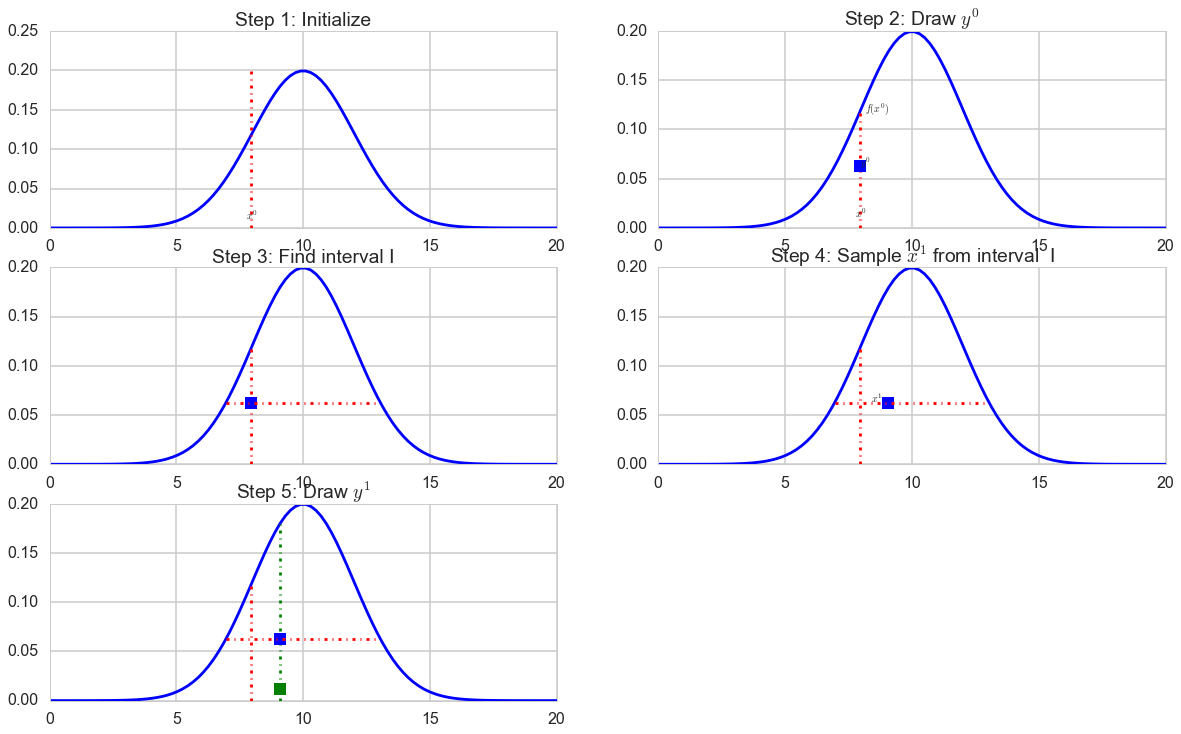

In [3]:
#sns.set()
x = np.linspace(0,20, 100)

plt.figure(figsize=[20,12])

plt.subplot(3,2,1)
plt.plot(x, fun(x), 'b')

np.random.seed(17)
x0=np.random.uniform(low=5, high=15, size=1)
plt.plot( [x0 ,x0], [0, 0.2], 'r-.')
plt.title('Step 1: Initialize')
plt.annotate( '$x^{0}$', [x0-0.2,.01], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)


plt.subplot(3,2,2)
plt.plot(x, fun(x), 'b')

plt.annotate( '$x^{0}$', [x0-0.2,.01], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)
plt.annotate( '$f(x^0)$', [x0+0.2, fun(x0)], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)



plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.title('Step 2: Draw $y^{0}$')
y0=np.random.uniform(low=0, high=fun(x0), size=1)
plt.plot( [x0,x0], [y0, y0], 'bs')

plt.annotate( '$y^{0}$', [x0,y0], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)

plt.subplot(3,2,3)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.plot( [x0,x0], [y0, y0], 'bs')


plt.plot( [invfunL(y0), invfunR(y0)] , [y0, y0], 'r-.')
#plt.plot( [2,4] , [y0, y0], 'r-.')
plt.title('Step 3: Find interval I') 

plt.subplot(3,2,4)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')

x1=np.random.uniform(low=8.5, high=11.5, size=1)
plt.plot( [x1,x1], [y0, y0], 'bs')
plt.plot( [invfunL(y0), invfunR(y0)] , [y0, y0], 'r-.')
#plt.plot( [2,4] , [y0, y0], 'r-.')
plt.title('Step 4: Sample $x^{1}$ from interval  I') 
plt.annotate( '$x^{1}$', [x1-0.7,y0], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)


plt.subplot(3,2,5)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.plot( [x1 ,x1], [0, fun(x1)], 'g-.')
y1=np.random.uniform(low=0, high=fun(x1), size=1)

plt.plot( [x1,x1], [y0, y0], 'bs')
plt.plot( [x1,x1], [y1, y1], 'gs')
plt.plot( [invfunL(y0), invfunR(y0)] , [y0, y0], 'r-.')
#plt.plot( [2,4] , [y0, y0], 'r-.')
plt.title('Step 5: Draw $y^1$') 
#plt.annotate( '$x^{1}$', [9.5,y0], xytext=None, xycoords='data',
#         textcoords='data', arrowprops=None)



This is workable assuming we can find the interval $I$. 

### What about the multimodal case ? 

In [4]:
mu1=3; mu2=10; sigma1=1; sigma2=2; l1=.30; l2=.70;

normal = 1./np.sqrt(2*np.pi*sigma2**2)

fun=lambda x: l1*norm.pdf(x, mu1, sigma1)+l2*norm.pdf(x, mu2, sigma2)

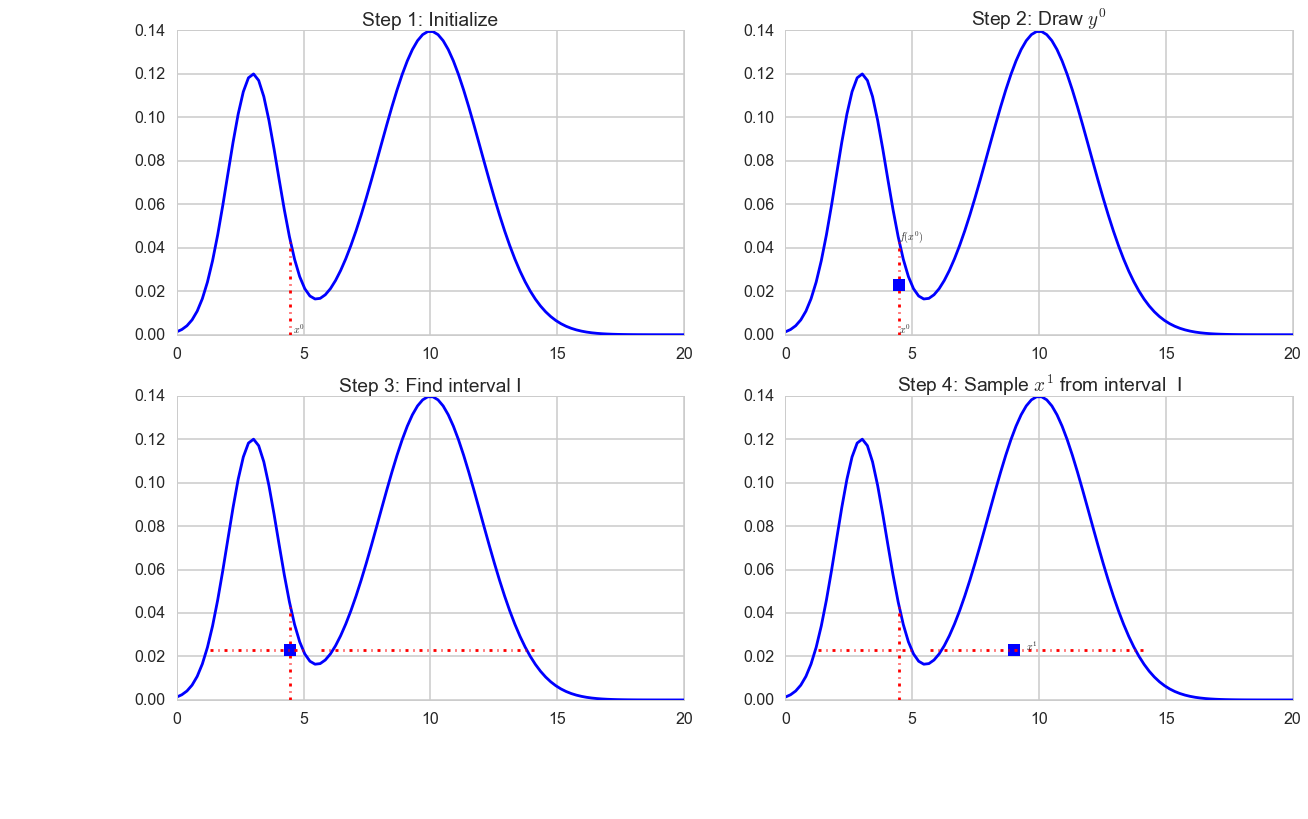

In [5]:
x = np.linspace(0,20, 100)

plt.figure(figsize=[20,12])

plt.subplot(2,2,1)
plt.plot(x, fun(x), 'b')

np.random.seed(16)
x0=np.random.uniform(low=0, high=20, size=1)
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.title('Step 1: Initialize')
plt.annotate( '$x^{0}$', [x0+0.1,.001], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)


plt.subplot(2,2,2)
plt.plot(x, fun(x), 'b')

plt.annotate( '$x^{0}$', [x0,.001], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)
plt.annotate( '$f(x^0)$', [x0,fun(x0)], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)



plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.title('Step 2: Draw $y^{0}$')
y0=np.random.uniform(low=0, high=fun(x0), size=1)
plt.plot( [x0,x0], [y0, y0], 'bs')

plt.annotate( '$y^{0}$', [10.5,.15], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)

plt.subplot(2,2,3)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.plot( [x0,x0], [y0, y0], 'bs')
plt.plot( [5.7,14.2] , [y0, y0], 'r-.')
plt.plot( [1.3,5.1] , [y0, y0], 'r-.')
plt.title('Step 3: Find interval I') 

plt.subplot(2,2,4)
plt.plot(x, fun(x), 'b')
plt.plot( [x0 ,x0], [0, fun(x0)], 'r-.')
plt.plot( [9,9], [y0, y0], 'bs')
plt.plot( [5.7,14.2] , [y0, y0], 'r-.')
plt.plot( [1.3,5.1] , [y0, y0], 'r-.')
plt.title('Step 4: Sample $x^{1}$ from interval  I') 
plt.annotate( '$x^{1}$', [9.5,y0], xytext=None, xycoords='data',
         textcoords='data', arrowprops=None)


The difficulty lies in steps 3 and 4.  If you know the inverse of f(x) then you could set  L = inf(S) (lower bound) and R = sup(S) (upper bound) as it is done in the unimodal example abpove. However in practice finding this region is not easy and there are various ways to do steps 3 and 4.

## Methods to Select the Univariate Window

There are a few different methods in the univariate case to select the Interval in Step 3 of the general procedure.  

1. Find the ideal bounds as described above in unimodal case 
2. If the range of $f(x)$ is bounded, then set the bounds of $f$ as your interval (L, R), draw $x$ from this interval and then reject/accept if it is below or above $f(x)$. 
3. A procedure known as "Stepping Out" and 
4. A procedure referred to as "Doubling."

(1) and (2) are usually infeasible for different reasons.  (1) is infeasible because it's in general not easy to find the inf and sup of arbitrary regions of f(x).  (2) is infeasible because in many cases the region S is much smaller than the bounded range of f(x) and sampling uniformly from the range of f(x) would be an inefficient way to sample from I.  Let's concentrate on stepping out: you can read about doubling, and about slice sampling in general,  in Fonnesbecks Bios8366 course, or in Radford Neal's [review](http://projecteuclid.org/download/pdf_1/euclid.aos/1056562461).  


### Stepping Out
The idea behind stepping out is that you expand your interval by fixed widths $w$ until your endpoints are outside of S.  The full algorithm is as follows:

* Set w = width of your interval expansions 
* draw u, v ~ Unif(0,1)
* set L = $ x^{(0)}  - w u, R = L + w$  (so $ x^{(0)} $ lies in [L, R] )
* while  y < f(L) (here's where we extend left interval)
   * L = L - w
* while y < f(R) ( here's where we extend the right interval)
   * R = R + w

The final interval will be larger than $S$. We will later see how we accept/reject to ensure our samples are from within $S$. 

In [6]:
import time
def plot_bounds(k, kmax, L, R, y, ts=1):
    if k <= kmax:
        plt.plot( [L,R], [y, y], 'r', marker=".", linestyle='None')
        plt.annotate("{}".format(k), xy=(L,y))
        plt.annotate("{}".format(k), xy=(R,y))
        #time.sleep(ts)
def plot_yline(k, kmax, xprev, y, f, ts=1):
    if k <= kmax:
        plt.plot( [x_prev ,x_prev], [0, f(x_prev)], 'r-', lw=1)
        plt.plot( [x_prev,x_prev], [y, y], 'rd', alpha=0.2)
        plt.annotate("{}".format(k), xy=(x_prev,y))
        #time.sleep(ts)
def plot_prop(k, kmax, x_prop, y, accept=None, ts=1):
    if accept=="y":
        symbol="ro"
        alpha=0.3
    elif accept=="n":
        symbol="ko"
        alpha=0.1
    else:
        symbol="bs"
        alpha=0.5
    if k <= kmax:
        plt.plot( [x_prop, x_prop], [y, y], symbol, alpha=alpha)
        plt.annotate("{}".format(k), xy=(x_prop,y))
        #time.sleep(ts)

L,R, xprop 0.0011959265323060464 16.001195926532304 3.570490993592926
L,R, xprop 1.4067595685920269 4.406759568592027 1.6177341690085278


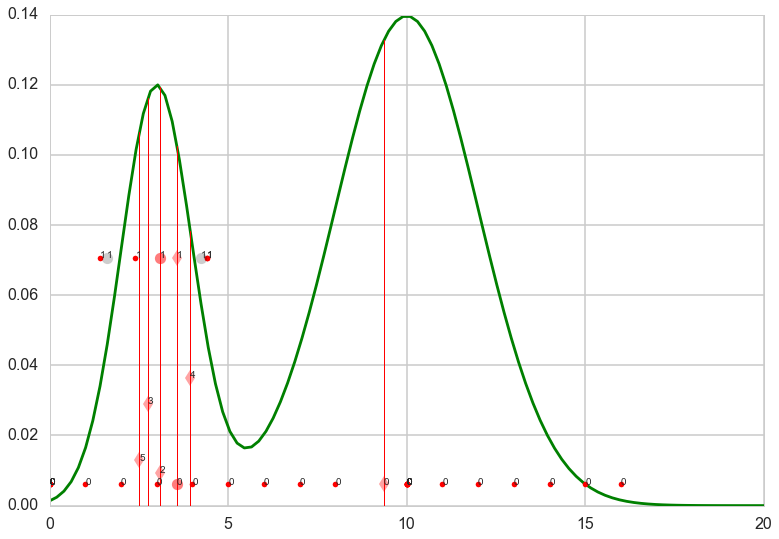

In [7]:
w=1.0
x = np.linspace(0,20, 100)
L=0; R=0;
x_prev = np.random.uniform(low=0, high=17)
fig = plt.figure()
iters=10000
trace=[]
kmax=1
plt.plot(x, fun(x),'g')
for k in range(iters):
    y_samp = np.random.uniform(low=0, high=fun(x_prev))
    plot_yline(k, 5, x_prev, y_samp, fun)
    # widen left
    U = np.random.rand()
    L=x_prev-U*w
    R=x_prev+w*(1.0-U)
    while fun(L)>y_samp:
        L = L-w
        plot_bounds(k, kmax, L, R, y_samp)
    while fun(R)>y_samp:
        R = R+w
        plot_bounds(k, kmax, L, R, y_samp)
    #now propose new x on L,R
    
    x_prop= np.random.uniform(low=L, high=R)
    if k <= kmax:
        print("L,R, xprop", L, R, x_prop)
    #now accept if kosher, ie if function at new x is higher than the y we sampled at prev x
    #plot_prop(k, kmax, x_prop, y_samp, accept=None)
    accept=False
    while accept==False:
        if y_samp < fun(x_prop):
            x_prev = x_prop
            trace.append(x_prop)
            plot_prop(k, kmax, x_prop, y_samp, accept='y')
            accept = True
        else: #propose again: in real slice we would shrink
            plot_prop(k, kmax, x_prop, y_samp, accept='n')
            x_prop= np.random.uniform(low=L, high=R)
        

plt.show()

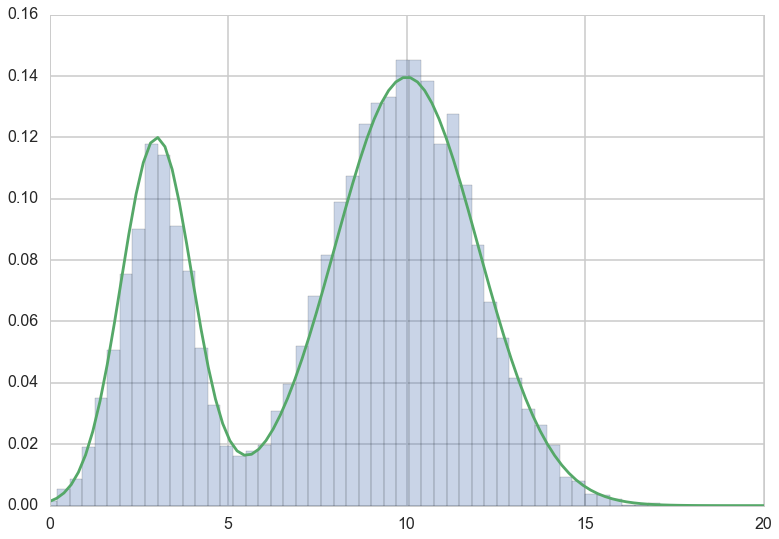

In [8]:
plt.hist(trace, bins=50, alpha=0.3, normed=True);
#sns.kdeplot(xsmp)
plt.xlim( [0,20])
plt.plot(x, fun(x))

## Methods to Sample from the Univariate Window

Once we've obtained our interval $I$, we want to sample from it.  However as constructed $I$ is likely to be larger than the actual set of acceptable proposals.  What are the set of acceptable proposals?  They have to satisfy the following criteria:

1.  They lie within $I$
2.  They lie within $S$
3.  They satisfy detail balance
  * Let's call our current sample $ x^{(0)} $
  * Let's call a possible proposal  x* 
  * x* would be an acceptable proposal if $ x_0 $ would be an acceptable proposal for x* if x* were the current sample 

We can call our set of acceptable proposals for a given $ x_0, A$.  


There are a few possible methods to sample from the interval.  

1. We can repeatedly sample from within $I$ until we obtain a point within $S$
2. We can try a procedure known as "shrinkage"

Repeatedly sampling from within $I$ as in 1), may not be efficient (especially if $S$ is much smaller than $I$).  Let's then explore the "shrinkage" procedures.

###  Conventional Shrinkage Procedure

The idea behind the shrinkage procedure is that you sample from your interval, if the sample's not in $S$, make that point the new endpoint of your interval decreasing the length of your interval.  Otherwise keep the sample and go back to the interval selection problem.

* start with  interval $I = (L, R)$
* current sample is $ x^{(k)} $ and $y^{(k)}$
* repeat until loop exits
   * sample $x^{*}$ uniformly from (L, R)
   * if $y^{(k)}< f(x^{*})$
      * accept x* and end loop
   * else
      * if $x^{*} <  x^{(k)} \rightarrow  L = x^{*}$ 
      * if $x^{*} > x^{(k)} \rightarrow  R = x^{*}$ 


L,R, xprop 5.7341772641248525 14.734177264124853 10.587971614261836
L,R, xprop 6.563927342922048 13.563927342922048 9.600656668878845


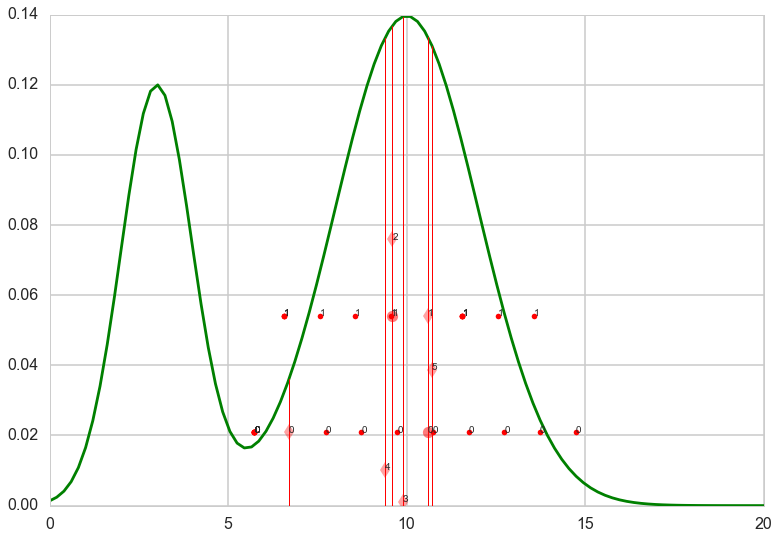

In [11]:
w=1.0
x = np.linspace(0,20, 100)
L=0; R=0;
x_prev = np.random.uniform(low=0, high=17)
fig = plt.figure()
iters=10000
trace=[]
kmax=1
plt.plot(x, fun(x),'g')
for k in range(iters):
    y_samp = np.random.uniform(low=0, high=fun(x_prev))
    plot_yline(k, 5, x_prev, y_samp, fun)
    # widen left
    U = np.random.rand()
    L=x_prev-U*w
    R=x_prev+w*(1.0-U)
    while fun(L)>y_samp:
        L = L-w
        plot_bounds(k, kmax, L, R, y_samp)
    while fun(R)>y_samp:
        R = R+w
        plot_bounds(k, kmax, L, R, y_samp)
    #now propose new x on L,R
    
    while 1:
        x_prop= np.random.uniform(low=L, high=R)
        if k <= kmax:
            print("L,R, xprop", L, R, x_prop)
        if y_samp < fun(x_prop):
            x_prev = x_prop
            trace.append(x_prop)
            plot_prop(k, kmax, x_prop, y_samp, accept='y')
            break
        elif x_prop > x_prev:
                R = x_prop
        elif x_prop < x_prev:
                L = x_prop
        

plt.show()

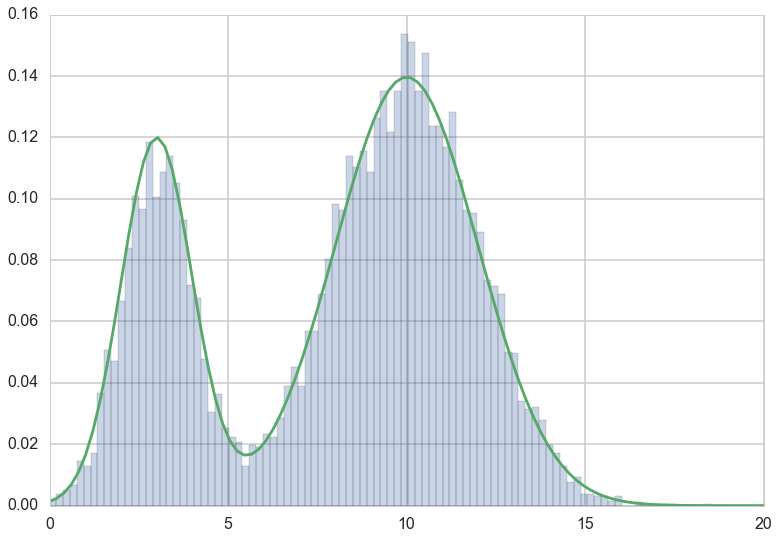

In [13]:
plt.hist(trace, bins=100, alpha=0.3, normed=True);
#sns.kdeplot(xsmp)
plt.xlim( [0,20])
plt.plot(x, fun(x))

### Revisiting the Univariate Slice Sampling Algorithm

With all that background, our univariate slice sampling algorithm should be clear

* Pick an initial point $ x_0 $ from our posterior
* Draw $ y_0 $ from U(0, f($x_0$))
* Repeat for N samples
  * Select the interval (e.g. stepping out, etc)
  * Sample $ x_i $ from that interval (e.g. shrinkage)
  * Draw $ y_i $ from U(0, f($x_i$))

## Revisiting Data Augmentation

Let's look a bit more closely at Data Augmentation and it's relationship to Slice Sampling.  If you recall the exact procedure for data augmentation is as follows. 

You're given $ X $ from which you wish to sample.  Sampling from them is difficult but with the addition of some auxilliary variables $ Y $ you're able to sample from the joint probability $p(X,Y)$ so that :

1.  the conditionals $X \vert Y$ and $Y \vert X$ are easy to sample 
2.  the marginal $p(X)$ from the joint $p(X,Y)$ matches your target distribution.
3.  You can then use Gibbs Sampling to generate samples for the joint distribution and keep the X samples 


Now let's look more closely at our slice sampling procedure.  

* We're given X
* We add an auxiliary variable Y 
* The marginals are easy to sample
   * $Y \vert X ~ Unif(0,f(x))]$
   * $X \vert Y = 1$ if $f(x) > y$ and 0 otherwise
* the marginal of X matches our target distribution by construction
* we use Gibbs sampling to generate our samples

IT's A DATA AUGMENTATION PROCEDURE!  The only difference is that we don't explicitly know our joint distribution.

